# **Spatiotemporal demand forecasting with neural networks**

In [90]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from utils import (
    load_data, 
    summarize_data, summary_plots, map_hotspot,
    grid_data, widen_grid_data, make_3d_array,
    plot_timeseries_cells,
    plot_grid, split_data,
    WindowGenerator, compile_and_fit, make_ypred
)
from constants import BATCH_SIZE, MAX_EPOCHS, NROW, NCOL

### **Get data**

The data consists of X-Y-t (longitude, latitude, time) coordinates of demand events. The goal is to create models that can predict the spatiotemporal distribution of these events in the near future.

In [2]:
demand = load_data('data/demand.csv')

In [3]:
demand.head()

,start_lat,start_lng
start_time,,
2022-03-06 15:02:39.329452,59.407910,24.689836
2022-03-10 11:15:55.177526,59.441650,24.762712
2022-03-06 14:23:33.893257,59.435404,24.749795
2022-03-03 09:11:59.104192,59.406920,24.659006
2022-03-06 00:13:01.290346,59.434940,24.753641


### **Explore data**

In [4]:
summarize_data(demand)

Total no. events = 627,210
Time range = 2022-03-01 00:00 - 2022-03-28 23:59


Spatiotemporal distribution of events shows daily activity pattern and strong concentration in a hotspot. Slight increase from Mo. to Sa., and over the weeks of March. Last week is incomplete (!). 

**Not possible to assess/model seasonal pattern (winter-spring-summer-autumn) with just one month, as well as multi-annual trends.**

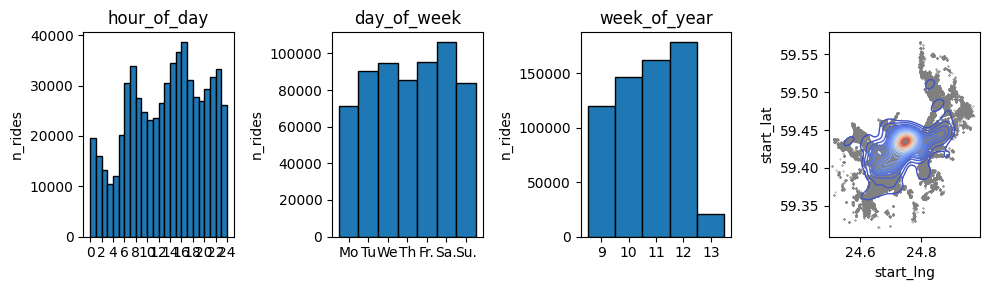

In [5]:
summary_plots(demand)

Zooming in to the downtown hotspot doesn't show any further spatial structure

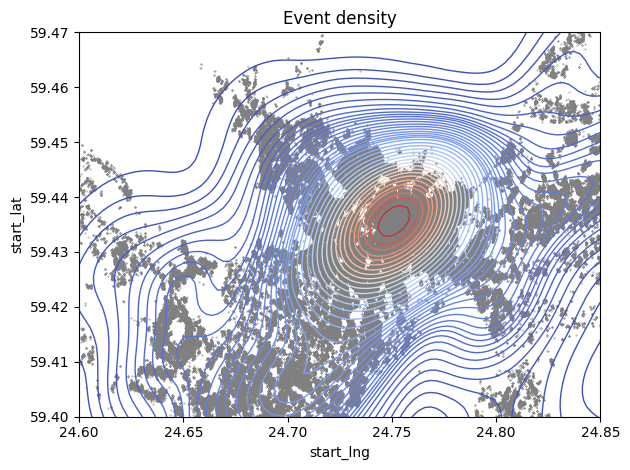

In [6]:
map_hotspot(demand)

### **Feature engineering - `n_events`**

The original continuous dataset can be grouped into temporal and lat-long bins to create a discrete spatiotemporal distribution of event counts -> `n_events`

In [4]:
gridded_data = grid_data(demand, nrow=NROW, ncol=NCOL, tbin='10min')

In [5]:
gridded_data.head(4)

,time_bin,lat_bin,lng_bin,n_events
0,2022-03-01,"(59.322, 59.371]","(24.505, 24.599]",0
1,2022-03-01,"(59.322, 59.371]","(24.599, 24.693]",2
2,2022-03-01,"(59.322, 59.371]","(24.693, 24.786]",0
3,2022-03-01,"(59.322, 59.371]","(24.786, 24.88]",0


In [6]:
gridded_data_wide = widen_grid_data(gridded_data)

In [7]:
gridded_data_wide.head(4)

,"lat_bin_(59.322, 59.371]_lng_bin_(24.505, 24.599]","lat_bin_(59.322, 59.371]_lng_bin_(24.599, 24.693]","lat_bin_(59.322, 59.371]_lng_bin_(24.693, 24.786]","lat_bin_(59.322, 59.371]_lng_bin_(24.786, 24.88]","lat_bin_(59.322, 59.371]_lng_bin_(24.88, 24.974]","lat_bin_(59.371, 59.42]_lng_bin_(24.505, 24.599]","lat_bin_(59.371, 59.42]_lng_bin_(24.599, 24.693]","lat_bin_(59.371, 59.42]_lng_bin_(24.693, 24.786]","lat_bin_(59.371, 59.42]_lng_bin_(24.786, 24.88]","lat_bin_(59.371, 59.42]_lng_bin_(24.88, 24.974]",...,"lat_bin_(59.469, 59.518]_lng_bin_(24.505, 24.599]","lat_bin_(59.469, 59.518]_lng_bin_(24.599, 24.693]","lat_bin_(59.469, 59.518]_lng_bin_(24.693, 24.786]","lat_bin_(59.469, 59.518]_lng_bin_(24.786, 24.88]","lat_bin_(59.469, 59.518]_lng_bin_(24.88, 24.974]","lat_bin_(59.518, 59.567]_lng_bin_(24.505, 24.599]","lat_bin_(59.518, 59.567]_lng_bin_(24.599, 24.693]","lat_bin_(59.518, 59.567]_lng_bin_(24.693, 24.786]","lat_bin_(59.518, 59.567]_lng_bin_(24.786, 24.88]","lat_bin_(59.518, 59.567]_lng_bin_(24.88, 24.974]"
time_bin,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,0,2,0,0,0,0,8,9,1,0,...,0,0,0,0,2,0,0,0,0,0
2022-03-01 00:10:00,1,0,0,0,0,0,14,9,0,0,...,0,0,0,3,2,0,0,0,1,0
2022-03-01 00:20:00,0,0,0,0,0,0,7,7,2,1,...,0,0,0,1,0,0,0,0,0,0
2022-03-01 00:30:00,0,2,1,0,0,0,10,3,1,0,...,0,0,0,4,0,0,0,0,0,0


Plotting the discrete spatial distribution of total events in the study period shows again that most of the activity is concentrated in a hotspot

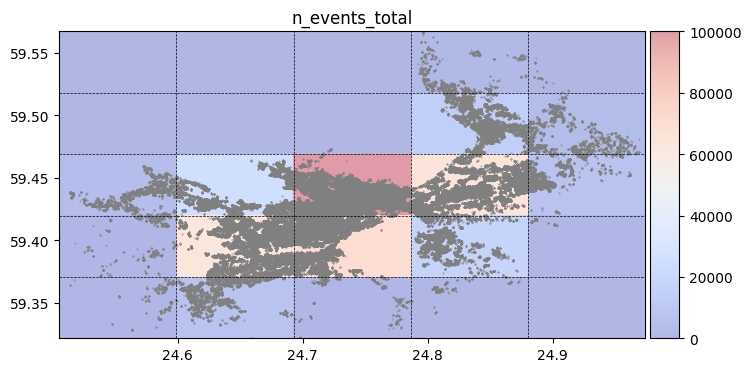

In [8]:
grid_3d = make_3d_array(gridded_data_wide, NROW, NCOL)

plot_grid(demand, grid_3d, NROW, NCOL, zmax=1e5)

Add a column with the total number of events to the wide dataset and plot. The plot shows that this concentration of events happens throughout the entire study period. For this reason, modelling will be done at several spatial levels: first, the total number of events will be modelled, and then single models for individual cells will be fitted.

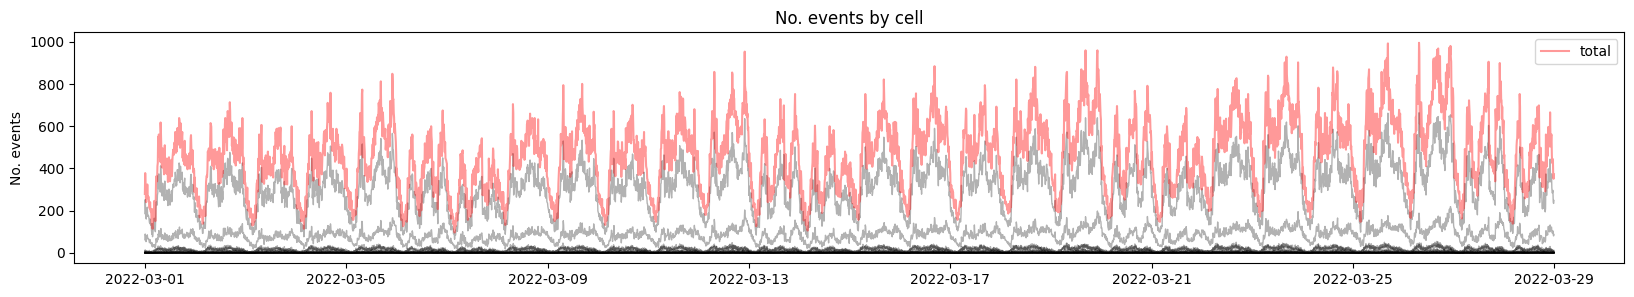

In [64]:
gridded_data_wide['n_events_total'] = gridded_data_wide.sum(axis=1)

plot_timeseries_cells(gridded_data_wide)

### **Windowing**

Data for autoregressive models must be structured in the form of a lagged dataset where features are the backshifted values of the variables ($t-1, t-2, ...$) and labels are their current values ($t$).

First, split the data into train, val and test datasets:

In [66]:
datasets = split_data(gridded_data_wide, f_train=0.6, f_val=0.2)

train: (2419, 26)
val: (806, 26)
test: (807, 26)


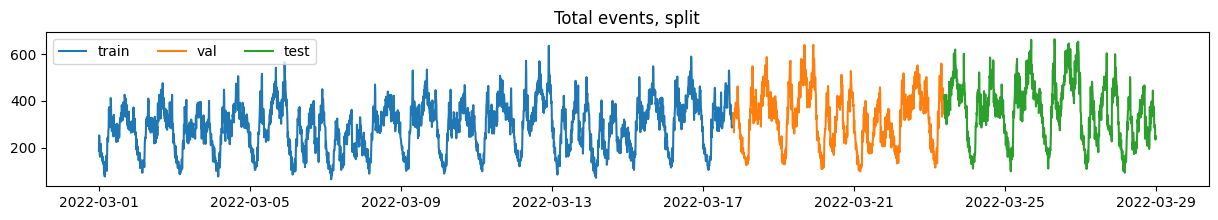

In [67]:
fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(datasets['train_timestamps'], datasets['train_df_original']['n_events_total'], label='train')
ax.plot(datasets['val_timestamps'], datasets['val_df_original']['n_events_total'], label='val')
ax.plot(datasets['test_timestamps'], datasets['test_df_original']['n_events_total'], label='test')
ax.set_title('Total events, split')
ax.legend(ncol=3)
plt.show()

Then, use utility class `WindowGenerator` (based on [this guide](https://www.tensorflow.org/tutorials/structured_data/time_series)) to take care of the windowing and lagging. This class and its methods return batches of data based on `tf.keras.utils.timeseries_dataset_from_array()` to be fed into the model during training. Each returned batch is of shape `(BATCH_SIZE, N_TIMESTEPS, N_FEATURES)`.

Here's an example batch using the split datasets from above, and using only the total no. of events `n_events_total` (the same can be done for individual cells): 

In [ ]:
w_dummy = WindowGenerator(
    input_width=6*12, 
    label_width=1, 
    offset=1, 
    train_df=datasets['train_df'][['n_events_total']],
    val_df=datasets['val_df'][['n_events_total']],
    test_df=datasets['test_df'][['n_events_total']],
    label_columns=['n_events_total'],
    batch_size=BATCH_SIZE)

print(f'X shape = {w_dummy.example[0].shape}')
print(f'y shape = {w_dummy.example[1].shape}')

X shape = (32, 72, 1)
y shape = (32, 1, 1)


### **Modelling `n_events_total`**

First, let's try a 1D convolutional model. Input width is the number of 10-min. timesteps from the past used as predictors and label width is 1.

In [174]:
CONV_WIDTH = 12*6
LABEL_WIDTH = 1
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

conv = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=3, kernel_size=(CONV_WIDTH,), activation='relu'),
#    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1),
])

w_conv = WindowGenerator(
    input_width=INPUT_WIDTH, 
    label_width=LABEL_WIDTH, 
    offset=1, 
    train_df=datasets['train_df'][['n_events_total']],
    val_df=datasets['val_df'][['n_events_total']],
    test_df=datasets['test_df'][['n_events_total']],
    batch_size=BATCH_SIZE,
    label_columns=['n_events_total'])

print(f'X shape = {w_conv.example[0].shape}')
print(f'y_pred shape = {conv(w_conv.example[0]).shape}')
print(f'y_obs shape = {w_conv.example[1].shape}')

conv(w_conv.example[0]) # build model to get number of parameters
    
print(f'Estimating {conv.count_params():,} parameters on {w_conv.train_df.shape[0]:,} datapoints')

X shape = (32, 72, 1)
y_pred shape = (32, 1, 1)
y_obs shape = (32, 1, 1)
Estimating 223 parameters on 2,419 datapoints


In [175]:
history_conv = compile_and_fit(conv, w_conv, max_epochs=MAX_EPOCHS, patience=20)

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9523 - mean_absolute_error: 0.8020 - val_loss: 0.5406 - val_mean_absolute_error: 0.5793
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3361 - mean_absolute_error: 0.4587 - val_loss: 0.3823 - val_mean_absolute_error: 0.4730
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2509 - mean_absolute_error: 0.3897 - val_loss: 0.3385 - val_mean_absolute_error: 0.4446
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2240 - mean_absolute_error: 0.3680 - val_loss: 0.3133 - val_mean_absolute_error: 0.4293
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2047 - mean_absolute_error: 0.3512 - val_loss: 0.2790 - val_mean_absolute_error: 0.4060
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1844 - mean_absolute_error: 0.3347 - val_loss: 0.2590 - val_mean_absolute_error: 0.3918
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1780 - mean_absolute_error: 0.3260 - val_loss

In [176]:
ypred_conv = make_ypred(conv, w_conv, datasets['train_mean']['n_events_total'], datasets['train_sd']['n_events_total'])

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Now let's try an LSTM

In [177]:
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=10, return_sequences=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

w_lstm = WindowGenerator(
    input_width=12*6, 
    label_width=1, 
    offset=1, 
    train_df=datasets['train_df'][['n_events_total']],
    val_df=datasets['val_df'][['n_events_total']],
    test_df=datasets['test_df'][['n_events_total']],
    batch_size=BATCH_SIZE,
    label_columns=['n_events_total'])

lstm(w_lstm.example[0]) # build model to get number of parameters

print(f'input shape = {w_lstm.example[0].shape}')
print(f'output shape = {lstm(w_lstm.example[0]).shape}')
print(f'output data shape = {w_lstm.example[1].shape}')
print(f'Estimating {lstm.count_params():,} parameters on {w_lstm.train_df.shape[0]:,} datapoints')

input shape = (32, 72, 1)
output shape = (32, 1, 1)
output data shape = (32, 1, 1)
Estimating 531 parameters on 2,419 datapoints


In [163]:
history_lstm = compile_and_fit(lstm, w_lstm, max_epochs=MAX_EPOCHS, patience=5)

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2118 - mean_absolute_error: 0.3591 - val_loss: 1.0951 - val_mean_absolute_error: 0.8682
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1724 - mean_absolute_error: 0.3226 - val_loss: 0.9619 - val_mean_absolute_error: 0.8082
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1824 - mean_absolute_error: 0.3318 - val_loss: 0.8620 - val_mean_absolute_error: 0.7605
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1752 - mean_absolute_error: 0.3277 - val_loss: 0.6911 - val_mean_absolute_error: 0.6739
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1640 - mean_absolute_error: 0.3120 - val_loss: 0.5678 - val_mean_absolute_error: 0.6062
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1757 - mean_absolute_error: 0.3246 - val_loss: 0.4055 - val_mean_absolute_error: 0.5075
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1841 - mean_absolute_error: 0.3379 - v

In [154]:
ypred_lstm = make_ypred(lstm, w_lstm, datasets['train_mean']['n_events_total'], datasets['train_sd']['n_events_total'])

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


#### **Results**



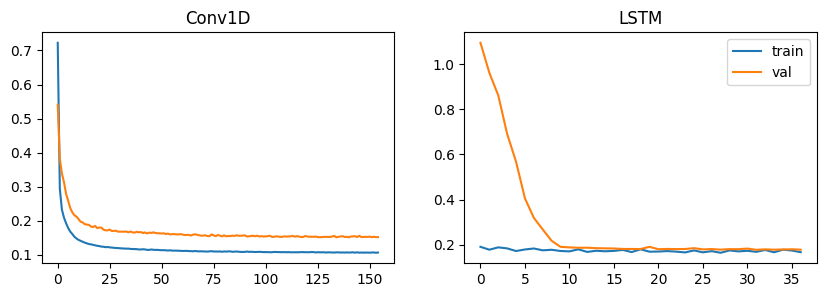

In [179]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(history_conv.history['loss'], label='train')
ax[0].plot(history_conv.history['val_loss'], label='val')
ax[1].plot(history_lstm.history['loss'], label='train')
ax[1].plot(history_lstm.history['val_loss'], label='val')
ax[1].legend()
ax[0].set_title('Conv1D')
ax[1].set_title('LSTM')
plt.show()

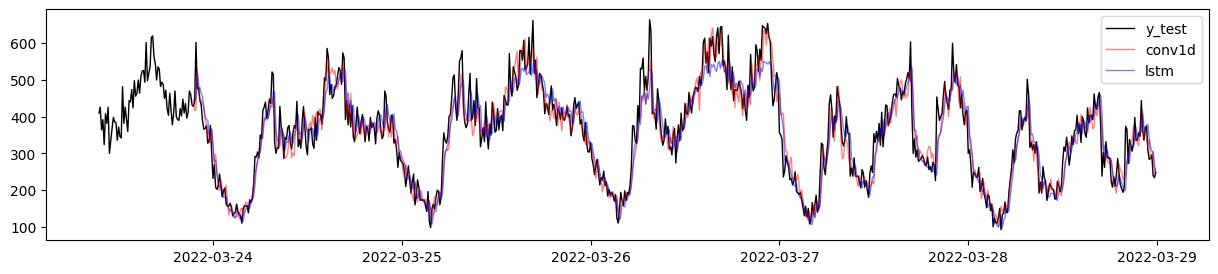

In [178]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(datasets['test_timestamps'], datasets['test_df_original']['n_events_total'], linewidth=1, color='black', label='y_test')
ax.plot(datasets['test_timestamps'], ypred_conv, linewidth=1, color='red', alpha=0.5, label=f'conv1d')
ax.plot(datasets['test_timestamps'], ypred_lstm, linewidth=1, color='blue', alpha=0.5, label=f'lstm')
ax.legend()
plt.show()

In [29]:
err_conv = ypred_conv - test_df_original['n_rides_total']
#err_lstm = ypred_lstm - test_df_original['n_rides_total']

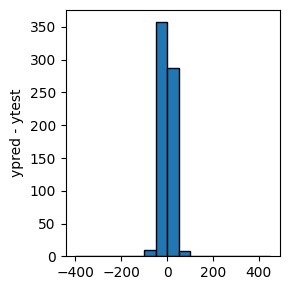

In [30]:
bins = np.arange(-400, 500, 50)

fig, ax = plt.subplots(figsize=(3, 3))
ax.hist(err_conv, edgecolor='black', bins=bins)
ax.set_ylabel('ypred - ytest')
plt.tight_layout()
plt.show()

In [31]:
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=10, return_sequences=False),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

w_lstm = WindowGenerator(input_width=12, label_width=1, offset=1, label_columns=['T (degC)'])

print(f'input shape = {w_lstm.example[0].shape}')
print(f'output shape = {lstm(w_lstm.example[0]).shape}')
print(f'output data shape = {w_lstm.example[1].shape}')

KeyError: in user code:

    File "C:\Users\RobertoTatisMuvdi\AppData\Local\Temp\ipykernel_2860\944550062.py", line 47, in split_window  *
        labels = tf.stack(

    KeyError: 'T (degC)'


### **Check stationarity**

In [18]:
check_stationarity_of_single_series(gridded_data, 0, 0)

ADF Statistic: -24.10
p-value: 0.00


Over the long-term (> month), the data seems stationary. However, there are very clear small-scale seasonal patterns: daily, weekly, and possibly also seasonally (> month, < year). However, these cannot be determined because the data spans only one month. 

In the modelling below, small-scale seasonality is included simply by allowing the models to have an observation window (in VAR: `maxlags`, in LSTM: `sample_size`) that is longer than seasonal cycles (e.g., if we have hourly data and expect daily cycle, the window should be > 24 units, i.e., >24 hours). I also explored creating dummy variables to capture seasonal effects (`hour_of_day`, `day_of_week`, etc.), but results were the same.

### **Check autocorrelation (ACF) and partial autocorrelation function (PACF)**

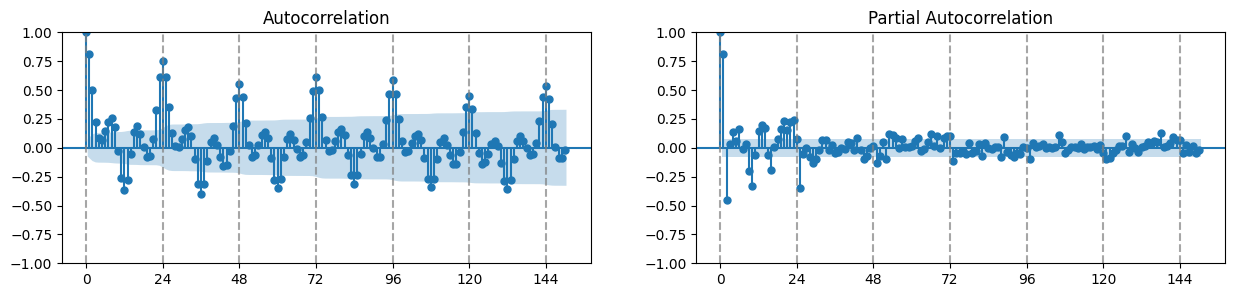

In [19]:
check_ac_structure(gridded_data, i=2, j=2)

The ACF confirms seasonality: there are significant peaks at lags 1h, 2h, 24h, 48h, 72h, ... At the same time: 

- The ACF exhibits a **tapering pattern** around each seasonal peak (as opposed to an abrupt drop)
- The PACF shows significant peaks **only** around the seasonal cycles, and then drops to the non-significant region

This combination suggests a **seasonal autorregressive process**.

### **Modelling approach 1: Vector Autoregressive Model VAR**

*Shumway & Stoffer (2011). Time Series Analysis and Its Applications*

Example with two time series $x_1$ and $x_2$:

$x_{t,1} = \alpha_1 + \phi_{1,1} x_{t-1, 1} + \phi_{1,2} x_{t-1, 2} +  w_{t, 1}$

$x_{t,2} = \alpha_2 + \phi_{2,1} x_{t-1, 1} + \phi_{2,2} x_{t-1, 2} +  w_{t, 2}$

In [20]:
results_var = model_var(gridded_data_wide, split=24*10, maxlags=24)

15,025 params. on 10,800 datapoints


#### Assess results on **chronological test set** (last 240 timesteps)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

rmse_cells = np.sqrt(1/results_var['test'].shape[0] * np.sum( (results_var['test'] - results_var['forecast']) ** 2, axis=0)) 

rmse_cells

lat_bin_(59.322, 59.371]_lng_bin_(24.505, 24.599]      2181.931301
lat_bin_(59.322, 59.371]_lng_bin_(24.599, 24.693]     37522.953386
lat_bin_(59.322, 59.371]_lng_bin_(24.693, 24.786]     13035.236571
lat_bin_(59.322, 59.371]_lng_bin_(24.786, 24.88]       4929.106003
lat_bin_(59.322, 59.371]_lng_bin_(24.88, 24.974]          0.000000
lat_bin_(59.371, 59.42]_lng_bin_(24.505, 24.599]       4498.687165
lat_bin_(59.371, 59.42]_lng_bin_(24.599, 24.693]      22471.297187
lat_bin_(59.371, 59.42]_lng_bin_(24.693, 24.786]     195176.802089
lat_bin_(59.371, 59.42]_lng_bin_(24.786, 24.88]      106943.481975
lat_bin_(59.371, 59.42]_lng_bin_(24.88, 24.974]       12085.643090
lat_bin_(59.42, 59.469]_lng_bin_(24.505, 24.599]       7104.691531
lat_bin_(59.42, 59.469]_lng_bin_(24.599, 24.693]      23657.124217
lat_bin_(59.42, 59.469]_lng_bin_(24.693, 24.786]     127054.392827
lat_bin_(59.42, 59.469]_lng_bin_(24.786, 24.88]       72015.254196
lat_bin_(59.42, 59.469]_lng_bin_(24.88, 24.974]       56084.65

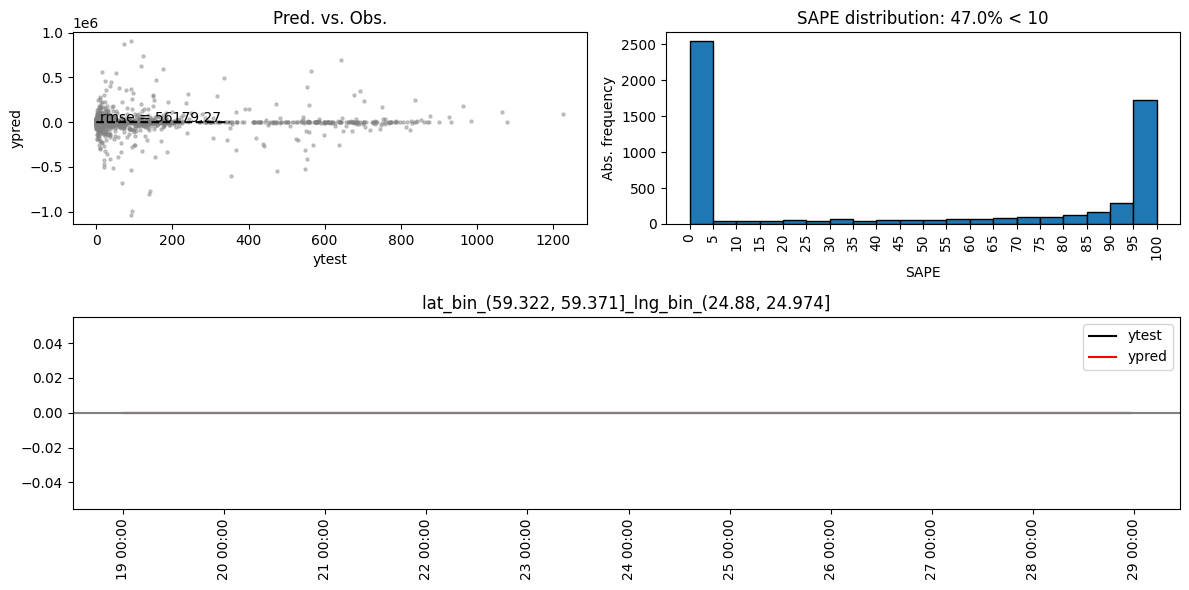

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_var(results, error_threshold, cell):

    fig = plt.figure(figsize=(12, 6))

    gs = fig.add_gridspec(2, 2)

    ax0 = fig.add_subplot(gs[0, 0])
    ax0.scatter(results['ytest'], results['ypred'], color='gray', s=5, alpha=0.4)
    ax0.plot([0, 350], [0, 350], 'k--')
    ax0.set_title('Pred. vs. Obs.')
    ax0.set_xlabel('ytest')
    ax0.set_ylabel('ypred')
    ax0.text(x=10, y=300, s=f"rmse = {results['rmse']:.2f}") 

    ax2 = fig.add_subplot(gs[1, :])
    ax2.set_title(f"{results['gridded_data_wide'].columns[cell]}")
    ax2.plot(results['test'].iloc[:, cell], 'k-', label='ytest')
    ax2.plot(results['test'].index, results['forecast'][:, cell], 'r-', label='ypred')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
    ax2.tick_params(axis='x', rotation=90)
    ax2.axhline(y=0, color='gray')
    ax2.legend()

    sape_bins = np.arange(0, 105, 5)
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.set_title(f'SAPE distribution: {100.0*len(results['sape'][results['sape'] < error_threshold])/len(results['sape']):.1f}% < {error_threshold}')
    ax1.hist(results['sape'], bins=sape_bins, edgecolor='black')
    ax1.set_xticks(sape_bins)
    ax1.tick_params(axis='x', rotation=90)
    ax1.set_xlabel('SAPE')
    ax1.set_ylabel('Abs. frequency')
    
    plt.tight_layout()
    plt.show()


plot_var(results_var, error_threshold=10, cell=4)

### **Modelling approach 2: LSTM**

In [36]:

def model_lstm(gridded_data_wide, test_size, sample_size):

    train_size = len(gridded_data_wide) - test_size

    gridded_data_wide_train = gridded_data_wide[:train_size]
    gridded_data_wide_test = gridded_data_wide[train_size:]

    scaler = StandardScaler()
    gridded_data_wide_train_scaled = scaler.fit_transform(gridded_data_wide_train)
    gridded_data_wide_test_scaled = scaler.transform(gridded_data_wide_test)

    Xtrain, ytrain, Xtest, ytest  = [], [], [], []

    for i in range(gridded_data_wide_train_scaled.shape[0] - sample_size):
        Xtrain.append(gridded_data_wide_train_scaled[i:i + sample_size])
        ytrain.append(gridded_data_wide_train_scaled[i + sample_size])

    for i in range(gridded_data_wide_test.shape[0] - sample_size):
        Xtest.append(gridded_data_wide_test_scaled[i:i + sample_size])
        ytest.append(gridded_data_wide_test_scaled[i + sample_size])

    Xtrain, ytrain, Xtest, ytest = np.array(Xtrain), np.array(ytrain), np.array(Xtest), np.array(ytest)

    n_features = gridded_data_wide.shape[1]

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(sample_size, n_features)),
        tf.keras.layers.LSTM(10, 'relu'),
        tf.keras.layers.Dense(n_features)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(Xtrain, ytrain, epochs=8, batch_size=20, validation_split=0.1, verbose=0)

    ypred = model.predict(Xtest)

    ypred_original = scaler.inverse_transform(ypred)
    ytest_original = scaler.inverse_transform(ytest)

    ypred_original_flattened = ypred_original.flatten()
    ytest_original_flattened = ytest_original.flatten()

    rmse = root_mean_squared_error(ytest_original, ypred_original)
    sape = compute_sape(ypred_original_flattened, ytest_original_flattened) 
    
    print(f'{model.count_params():,} params. on {Xtrain.size:,} datapoints')

    return {
        'rmse': rmse, 
        'model_fit': model, 
        'history': history, 
        'ypred': ypred_original, 
        'ytest': ytest_original,
        'gridded_data_wide': gridded_data_wide,
        'sape': sape,
    }


results_lstm = model_lstm(gridded_data_wide, test_size=24*10, sample_size=2)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
1,715 params. on 21,500 datapoints


#### Assess results on **chronological test set** (last 240 timesteps)

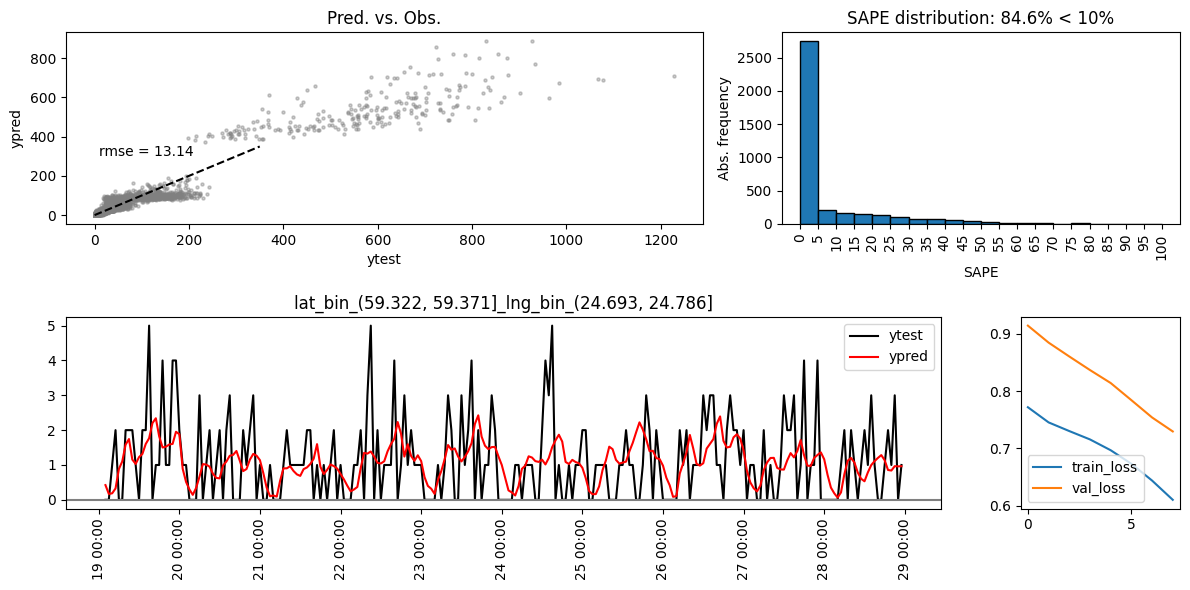

In [38]:
def plot_nn(results, error_threshold, cell):

    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 5)

    ax0 = fig.add_subplot(gs[0, :3])
    ax0.scatter(results['ytest'], results['ypred'], color='gray', s=5, alpha=0.4)
    ax0.plot([0, 350], [0, 350], 'k--')
    ax0.set_title('Pred. vs. Obs.')
    ax0.set_xlabel('ytest')
    ax0.set_ylabel('ypred')
    ax0.text(x=10, y=300, s=f"rmse = {results['rmse']:.2f}") 

    sape_bins = np.arange(0, 105, 5)
    ax1 = fig.add_subplot(gs[0, 3:])
    ax1.set_title(f'SAPE distribution: {100.0*len(results['sape'][results['sape'] < error_threshold])/len(results['sape']):.1f}% < {error_threshold}%')
    ax1.hist(results['sape'], bins=sape_bins, edgecolor='black')
    ax1.set_xticks(sape_bins)
    ax1.tick_params(axis='x', rotation=90)
    ax1.set_xlabel('SAPE')
    ax1.set_ylabel('Abs. frequency')

    ax2 = fig.add_subplot(gs[1, :4])
    ax2.set_title(f"{results['gridded_data_wide'].columns[cell]}")
    ax2.plot(results['gridded_data_wide'].iloc[-len(results['ytest']):, cell], 'k-', label='ytest')
    ax2.plot(results['gridded_data_wide'].iloc[-len(results['ytest']):, cell].index, results['ypred'][:, cell], 'r-', label='ypred')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
    ax2.tick_params(axis='x', rotation=90)
    ax2.axhline(y=0, color='gray')
    ax2.legend()

    ax3 = fig.add_subplot(gs[1, 4:])
    ax3.plot(results['history'].history['loss'], label='train_loss')
    ax3.plot(results['history'].history['val_loss'], label='val_loss')
    ax3.legend()    
    
    plt.tight_layout()
    plt.show()

plot_nn(results_lstm, error_threshold=10, cell=2)

### **Modelling approach 3: FNN on lagged dataset**

In [34]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import root_mean_squared_error


def compute_sape(ypred, ytest):
    '''
    Compute symmetrical absolute percentage errors
    '''

    def smape_i(ypred_i, ytest_i):
        if (ypred_i != 0.0) & (ytest_i != 0.0):
            return 100.0 * ((np.abs(ypred_i) - np.abs(ytest_i)) / (np.abs(ytest_i) + np.abs(ypred_i)))
        else:
            return 0.0
    return np.array(list(map(smape_i, ypred, ytest)))


def weighted_mse(y_true, y_pred):
    threshold = 7.0
    high_weight = 30.0
    weights = tf.where(y_true > threshold, high_weight, 1.0)
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))


def model_fnn(gridded_data_wide, test_size, lags):

    train_size = len(gridded_data_wide) - test_size

    gridded_data_wide_train = gridded_data_wide[:train_size]
    gridded_data_wide_test = gridded_data_wide[train_size:]

    scaler = StandardScaler(with_mean=True, with_std=True)
    gridded_data_wide_train_scaled = scaler.fit_transform(gridded_data_wide_train)
    gridded_data_wide_test_scaled = scaler.transform(gridded_data_wide_test)

    Xtrain, ytrain = [], []
    Xtest, ytest = [], []
    maxlag = max(lags)

    for lag in lags: 
        Xtrain.append(gridded_data_wide_train_scaled[(maxlag - lag):-lag])
        Xtest.append(gridded_data_wide_test_scaled[(maxlag - lag):-lag])

    ytrain = np.array(gridded_data_wide_train_scaled[maxlag:])
    #ytrain_log = np.log2(ytrain + 1)
    
    ytest = np.array(gridded_data_wide_test_scaled[maxlag:])
    
    Xtrain = np.stack([arr for arr in Xtrain])
    Xtest = np.stack([arr for arr in Xtest])
    
    # put time steps as 1st dimension, then put all features from all lags into a single dimension
    Xtrain_transposed = Xtrain.transpose(1, 0, 2).reshape(Xtrain.shape[1], -1) 
    Xtest_transposed = Xtest.transpose(1, 0, 2).reshape(Xtest.shape[1], -1)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(Xtrain_transposed.shape[1], )),
        tf.keras.layers.Dense(10, activation='tanh'),
        tf.keras.layers.Dense(ytrain.shape[1], activation='linear'),
    ])

    model.compile(optimizer='adam', loss='mse')

    print(f'{model.count_params():,} params. on {Xtrain.size:,} datapoints')

    history = model.fit(Xtrain_transposed, ytrain, epochs=8, batch_size=20, validation_split=0.1, verbose=0)
    
    #ypred_log = model.predict(Xtest_transposed)
    #ypred = (2 ** ypred_log) - 1
    ypred = model.predict(Xtest_transposed)

    ypred_original = scaler.inverse_transform(ypred)
    ytest_original = scaler.inverse_transform(ytest)

    ypred_original_flattened = ypred_original.flatten()
    ytest_original_flattened = ytest_original.flatten()

    rmse = root_mean_squared_error(ytest_original_flattened, ypred_original_flattened)
    sape = compute_sape(ypred_original_flattened, ytest_original_flattened) 

    return {
        'rmse': rmse, 
        'model_fit': model, 
        'history': history, 
        'ypred': ypred_original, 
        'ytest': ytest_original,
        'gridded_data_wide': gridded_data_wide,
        'sape': sape,
    }


results_fnn = model_fnn(gridded_data_wide, test_size=24*10, lags=[12, 24, 48])

1,035 params. on 28,800 datapoints
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


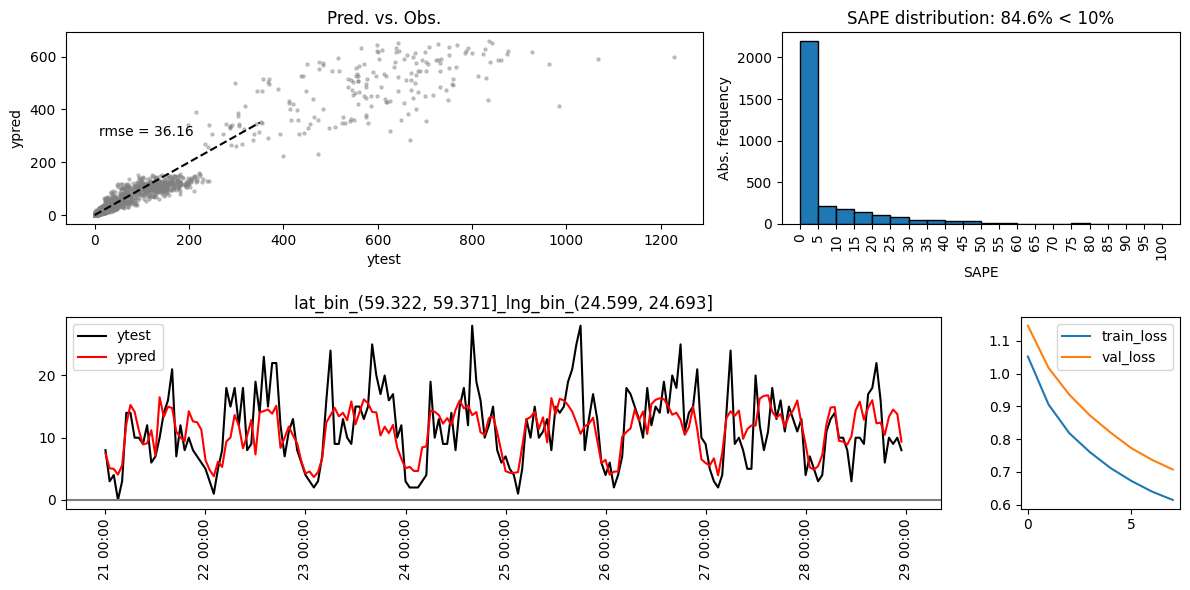

In [35]:
plot_nn(results_fnn, error_threshold=10, cell=1)

#### **Assessment**

- Overall both models good RMSE, slightly lower for VAR
- Error distribution symetrical around zero for both.
- 97% (VAR) and 96.3% (LSTM) of errors on **chronological test set**  <5 rides, good =)
- Daily trend well depicted. Need longer series to assess higher-scale trends (weekly, monthly, seasonal, multi-annual? -> sports events, big concerts, etc.)
- VAR has ~ 5 Mio. params, LSTM ~220k
- RMSE should also be assessed over space and time: group RMSE by hour, lat bin and long bin and check performance locally in space and time
- Looks like both models often miss/unterpredict hourly peaks. Must be addressed.

### **Notes**
- Only manual/intuitive optimization. In prod -> `keras tuner` or similar (focus on peaks, currently tend to be underestimated)
- Not good to have only one month, need full years to capture seasonal cycles
- `tf.keras.layers.ConvLSTM2D` with more data -> exploits spatial features *explicitly*. However, in VAR and LSTM they are used *implicitly* via cross-correlations 
- Assessing model impact in prod:
    - Expected effect: 
        - Overall better performance during rush hours and at hotspots
        - Riders spend less time finding a driver
        - Riders have shorter waiting times after finding a driver
        - Fewer unresponded ride requests (fewer times when riders don't find a driver)
        - Less idle time for drivers -> smaller time between rides
    - Experiment:
        - A/B test where we track above KPIs with and without model-driven steering
        - A/B groups must include comparable hours of the day, days of the week, weeks of the year, etc., and at comparable places given the demand distribution in the city
        - Test should include rush hours and lower-activity periods/areas 
- Model design and deployment:
    - Jupyter -> Module, include hyperparam. tuning
    - Repo -> ci/cd (`.github/workflows/cicd.yml`) -> github actions -> VM + gh runner
    - Dockerize
    - Run model as orchestrated (`airflow`) pipeline producing, e.g., weekly forecasts for the entire city. Maybe also weekly retraining as new data comes in.
    - Expose forecasts via api endpoint, e.g. `Flask`, where frontend sends desired coordinates and time and backend responds with `JSON` containing forecasted `n_rides`
- Communicate recommendations to drivers:
    - Map with simple indication of 'high demand expected here during time X'
    - Feature shows forecast for next 10 days or so 